# 🎥Netflix TV Show and Movie Recommendation System

### 1. Importing the Libraries

In [1]:
import pandas as pd
import random
import networkx as nx
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import ast

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aryag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aryag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2. Loading the Data 

In [2]:
df = pd.read_csv("titles.csv")


In [3]:
df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,NaN,134,['drama'],[],NaN,tt11803618,7.7,348.0,NaN,NaN
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,NaN,90,['comedy'],['CO'],NaN,tt14585902,3.8,68.0,26.005,6.300
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,[],['US'],NaN,NaN,NaN,NaN,1.296,10.000


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def visualize_raw_data(df):
    """
    Visualizes general trends in the movie dataset.
    """

    plt.figure(figsize=(15, 10))

    # ✅ (1) Genre Distribution
    plt.subplot(2, 2, 1)
    genre_counts = Counter([g for genre_list in df['genres'].dropna() for g in genre_list.split(', ')])
    top_genres = dict(sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:10])  # Top 10
    sns.barplot(x=list(top_genres.keys()), y=list(top_genres.values()), palette="viridis")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.title("🎭 Top 10 Most Common Genres")

    # ✅ (2) Production Countries Distribution
    plt.subplot(2, 2, 2)
    country_counts = Counter([c for country_list in df['production_countries'].dropna() for c in country_list.split(', ')])
    top_countries = dict(sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:5])  # Top 5
    plt.pie(top_countries.values(), labels=top_countries.keys(), autopct="%1.1f%%", colors=sns.color_palette("pastel"))
    plt.title("Top 5 Movie-Producing Countries")

    # ✅ (3) Movie Length Distribution
    plt.subplot(2, 2, 3)
    sns.histplot(df['runtime'].dropna(), bins=30, kde=True, color="blue")
    plt.xlabel("Runtime (minutes)")
    plt.ylabel("Number of Movies")
    plt.title("Distribution of Movie Runtimes")

    # ✅ (4) Cosine Similarity Heatmap (if tf-idf matrix exists)
    if 'cosine_similarity' in df.columns:
        plt.subplot(2, 2, 4)
        similarity_matrix = df[['cosine_similarity']].dropna().values.reshape(-1, 1)  # Reshape for heatmap
        sns.heatmap(similarity_matrix, cmap="coolwarm", cbar=True)
        plt.title("Cosine Similarity Distribution")

    plt.tight_layout()
    plt.show()


C:\Users\aryag\AppData\Local\Temp\ipykernel_16144\1201127128.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_genres.keys()), y=list(top_genres.values()), palette="viridis")
C:\Users\aryag\AppData\Local\Temp\ipykernel_16144\1201127128.py:42: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\aryag\Machine_Learning-Arya\NLP\Internship\lumaa-spring-2025-ai-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


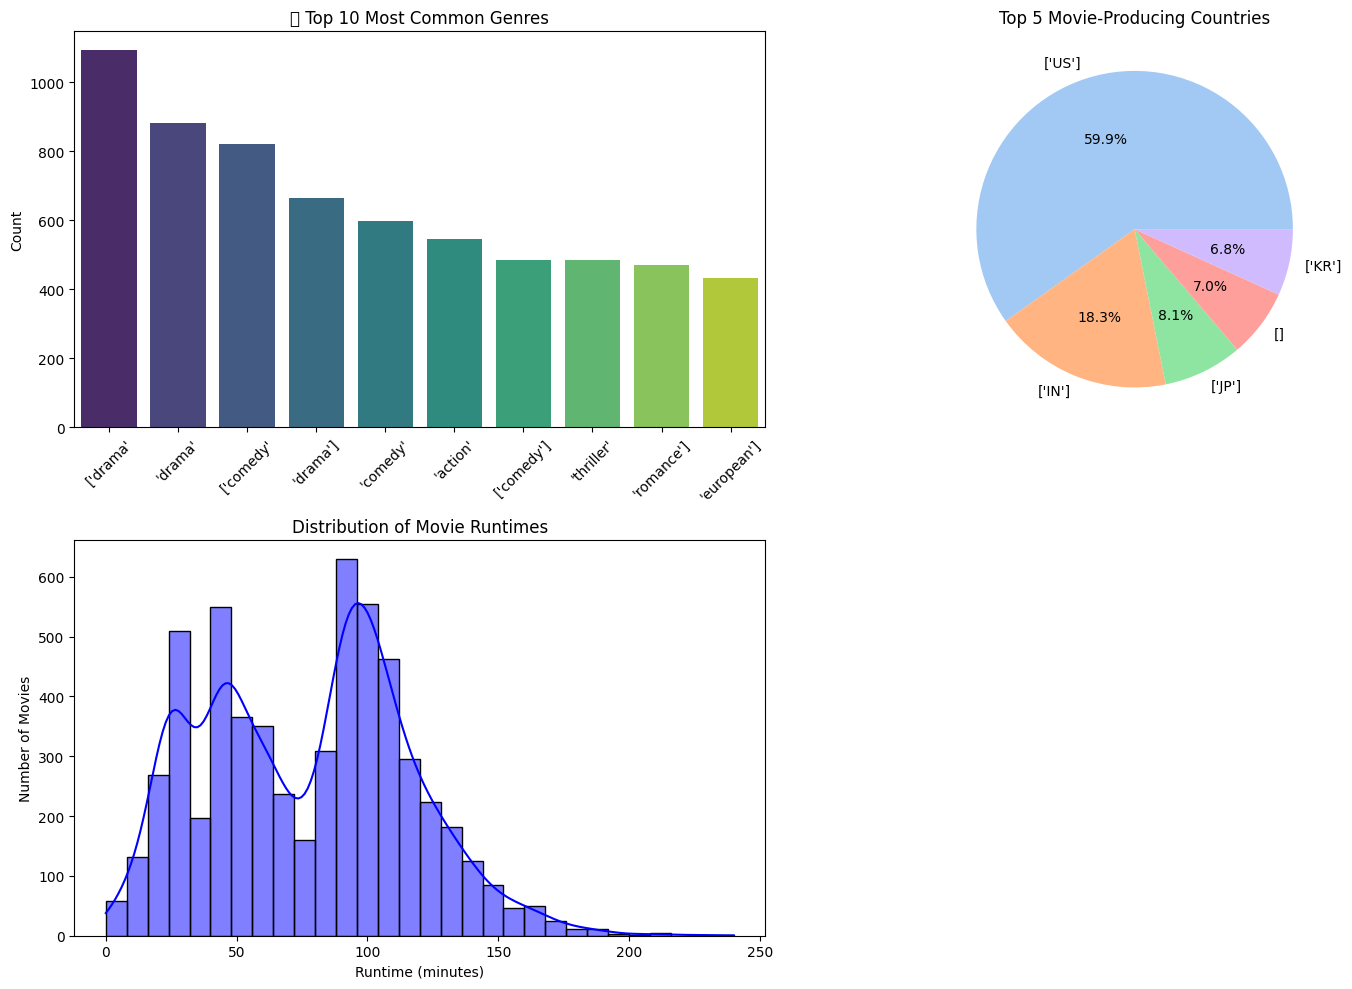

In [5]:
visualize_raw_data(df)


In [9]:
# For 'release_year'
print("Unique counts for 'release_year':")
print(df['release_year'].value_counts())
print("-" * 50)



Unique counts for 'release_year':
release_year
2019    836
2020    814
2021    787
2018    773
2017    563
       ... 
1971      1
1977      1
1958      1
1978      1
1963      1
Name: count, Length: 63, dtype: int64
--------------------------------------------------


### 3. Preprocessing Data

In [6]:
df['genres'] = df['genres'].apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(ast.literal_eval)

In [7]:
unique_values = df['genres'].explode().unique()


In [8]:
unique_values

array(['documentation', 'drama', 'crime', 'action', 'thriller',
       'european', 'fantasy', 'comedy', 'war', 'romance', 'western',
       'history', 'music', 'family', 'horror', 'scifi', 'animation',
       'reality', 'sport', nan], dtype=object)

In [9]:
def preprocess(text):
    if pd.isna(text) or not isinstance(text, str):  # Skip null or non-string values
        return ''
    
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)


In [10]:
GENRE_LIST = ['documentation', 'drama', 'crime', 'action', 'thriller',
       'european', 'fantasy', 'comedy', 'war', 'romance', 'western',
       'history', 'music', 'family', 'horror', 'scifi', 'animation',
       'reality', 'sport']

def extract_genres_from_query(user_query):
    doc = nlp(user_query.lower())
    extracted_genres = set()
    for token in doc:
        for genre in GENRE_LIST:
            if genre.lower() in token.text:
                extracted_genres.add(genre)
    return list(extracted_genres)

In [11]:
df['content']= df['title']+df['description']
df['processed_content'] = df['content'].apply(preprocess)

In [12]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['processed_content'].fillna(''))

### 4. TfIDF and cosine similarity

In [14]:
def hybrid_recommend(df, user_query, user_country=None, num_recommendations=10):
    """
    Hybrid Recommendation:
    1. Compute Cosine Similarity
    2. Show Top 5 Movies Based on Pure Cosine Similarity
    3. Show Next 5 Movies Based on Weighted Score (70% Cosine, 30% Genre Match)
    4. Handle Optional Country Filtering
    """

    # ✅ (A) Compute Cosine Similarity
    query_vector = vectorizer.transform([preprocess(user_query)])
    cosine_sim = cosine_similarity(query_vector, tfidf_matrix)

    # ✅ (B) Extract Genres from User Query (Only for Scoring)
    extracted_genres = extract_genres_from_query(user_query)
    print(f"📌 Detected Genres: {extracted_genres}")

    # ✅ (C) Compute Cosine Similarity Scores
    df_copy = df.copy()
    df_copy['cosine_similarity'] = cosine_sim[0]  # Assign similarity scores

    # ✅ (D) Compute Genre Match Score (1 if any genre matches, else 0) - No Filtering
    df_copy['genre_match'] = df_copy['genres'].apply(lambda x: 1 if any(genre in x for genre in extracted_genres) else 0)

    # ✅ (E) Compute Final Weighted Score
    df_copy['final_score'] = (0.7 * df_copy['cosine_similarity']) + (0.3 * df_copy['genre_match'])

    # ✅ (F) Country Filtering (if provided)
    if user_country and user_country.lower() not in ["any", ""]:
        df_copy = df_copy[df_copy['production_countries'].apply(lambda x: user_country in x)]

    # ✅ (G) Get Top 5 Movies Based on Pure Cosine Similarity
    top_5_cosine = df_copy.nlargest(5, 'cosine_similarity')

    # ✅ (H) Get Next 5 Movies Based on Weighted Score (excluding top 5)
    remaining_df = df_copy.drop(top_5_cosine.index)  # Remove top 5 from selection
    top_5_weighted = remaining_df.nlargest(5, 'final_score')

    # ✅ (I) Combine Results
    final_recommendations = pd.concat([top_5_cosine, top_5_weighted])

    return final_recommendations[['title', 'genres', 'production_countries', 'description']]


### 5. Results

In [15]:
# ✅ Example Query
user_query = "I love old movies"
user_country = "GB"

recommendations = hybrid_recommend(df, user_query, user_country, num_recommendations=10)

# 📢 Print recommendations in a well-formatted way
print("\n🔍 Top 10 Recommendations:\n")
for i, (_, row) in enumerate(recommendations.iterrows(), start=1):
    print(f"{i}. 🎬 {row['title']}")
    print(f"      📖 {row['description']}")
    print(f"      📖 {row['production_countries']}")
    print(f"      🎭 Genres: {', '.join(row['genres'])}")
    print("-" * 50)  # Separator for readability


📌 Detected Genres: []

🔍 Top 10 Recommendations:

1. 🎬 Still Game
      📖 Cult Scottish comedy about the lives of two OAP's (Old Age Pensioners) Jack and Victor and their views on how it used to be in the old days and how bad it is now in the fictional town of Craiglang.
      📖 ['GB']
      🎭 Genres: comedy, european
--------------------------------------------------
2. 🎬 Kingdom of Us
      📖 How does a traumatic event shape a family? How do you sift through the memories to find hidden clues and unlock a collective grief? Kingdom of Us takes a look at a mother and her seven children, whose father's suicide left them in financial ruin. Through home movies and raw moments, the Shanks family travels the rocky road towards hope.
      📖 ['GB']
      🎭 Genres: documentation, drama
--------------------------------------------------
3. 🎬 Before the Flying Circus
      📖 Discover how six seemingly ordinary but supremely talented men became Monty Python, sketch comedy's inspired group of luna

In [16]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
